In [10]:
# %config InlineBackend.figure_format = 'svg'
%matplotlib inline

from collections import namedtuple
from functools import partial
from pathlib import Path

from IPython.display import Audio

import librosa as lr
from librosa import display

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (14, 5)

import numpy as np
import scipy

In [41]:
def find_file(query, path):
    """Return a path to file in path if query is in filename. Raise FileNotFoundError if it does not exist."""
    file = sorted(p for p in path.iterdir() if query in p.name)[0]
    if not file.exists():
        raise FileNotFoundError
    return file

TrackClip = namedtuple('TrackClip', 'path start stop')

cwd = Path.cwd()
uncut = cwd / 'uncut'

find_song = partial(find_file, path=uncut)

hey_oh = TrackClip(find_song('hey_oh'), 0.0, 4.53)
funky_monks = TrackClip(find_song('funky_monks'), 11.27, 16.73)

track_clip = hey_oh

y, sr = lr.load(track_clip.path, 
                offset=track_clip.start, 
                duration=track_clip.stop - track_clip.start, 
#                 res_type='kaiser_fast',
               )
y.shape, sr, divmod(lr.get_duration(y), 60)

((99887,), 22050, (0.0, 4.530022675736961))

# Pitch Transcription Exercise

Load an audio file.

Play the audio file.

In [42]:
Audio(y, rate=sr)

Display the CQT of the signal.

In [48]:
bins_per_octave = 36
cqt = lr.cqt(y, sr=sr)
log_cqt = lr.amplitude_to_db(abs(cqt))

In [49]:
cqt.shape

(84, 196)

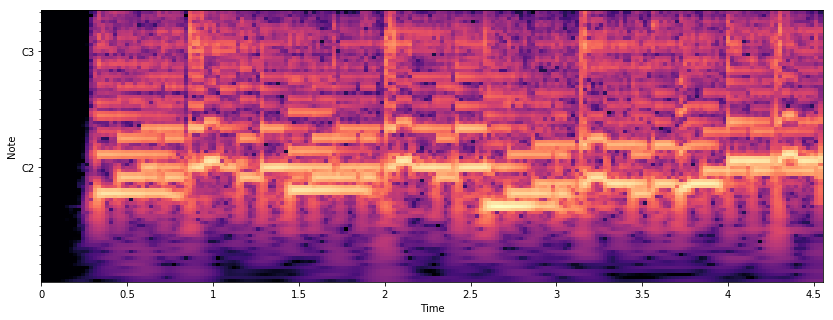

In [50]:
lr.display.specshow(log_cqt, sr=sr, x_axis='time', y_axis='cqt_note', 
                    bins_per_octave=bins_per_octave)

**Goal**: Identify the pitch of each note and replace each note with a pure tone of that pitch.

## Step 1: Detect Onsets

To accurately detect onsets, it may be helpful to see what the novelty function looks like:

In [51]:
hop_length = 100
onset_env = lr.onset.onset_strength(y, sr=sr, hop_length=hop_length)

(0, 999)

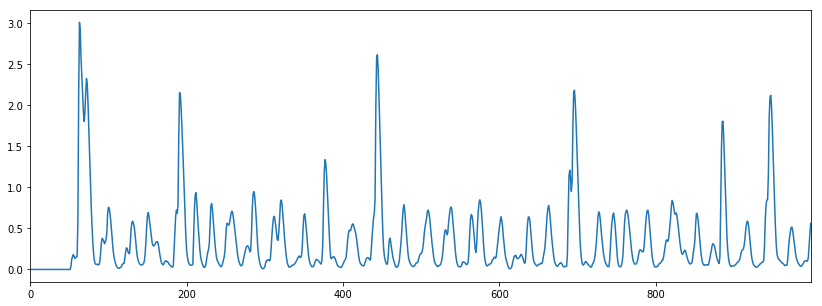

In [52]:
plt.plot(onset_env)
plt.xlim(0, len(onset_env))

Among the obvious large peaks, there are many smaller peaks. We want to choose parameters which preserve the large peaks while ignoring the small peaks.

Next, we try to detect onsets. For more details, see [`librosa.onset.onset_detect`](http://librosa.github.io/librosa/generated/librosa.onset.onset_detect.html#librosa.onset.onset_detect) and [`librosa.util.peak_pick`](http://librosa.github.io/librosa/generated/librosa.util.peak_pick.html#librosa.util.peak_pick).

In [53]:
onset_samples = lr.onset.onset_detect(y,
                                       sr=sr, units='samples', 
                                       hop_length=hop_length, 
                                       backtrack=False,
                                       pre_max=20,
                                       post_max=20,
                                       pre_avg=100,
                                       post_avg=100,
                                       delta=0.2,
                                       wait=0)

In [54]:
onset_samples

array([ 6300, 19100, 37700, 44400, 69600, 88600, 94700])

Let's pad the onsets with the beginning and end of the signal.

In [55]:
onset_boundaries = np.concatenate([[0], onset_samples, [len(y)]])
onset_boundaries

array([    0,  6300, 19100, 37700, 44400, 69600, 88600, 94700, 99887])

Convert the onsets to units of seconds:

In [56]:
onset_times = lr.samples_to_time(onset_boundaries, sr=sr)
onset_times

array([0.        , 0.28571429, 0.86621315, 1.70975057, 2.01360544,
       3.15646259, 4.01814059, 4.29478458, 4.53002268])

Display the results of the onset detection:

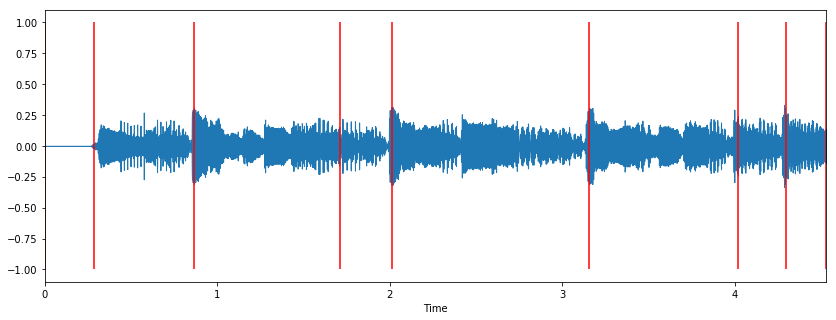

In [57]:
lr.display.waveplot(y, sr=sr)
plt.vlines(onset_times, -1, 1, color='r')

## Step 2: Estimate Pitch

Estimate pitch using the autocorrelation method:

In [58]:
def estimate_pitch(segment, sr, fmin=50.0, fmax=2000.0):
    
    # Compute autocorrelation of input segment.
    r = lr.autocorrelate(segment)
    
    # Define lower and upper limits for the autocorrelation argmax.
    i_min = sr/fmax
    i_max = sr/fmin
    r[:int(i_min)] = 0
    r[int(i_max):] = 0
    
    # Find the location of the maximum autocorrelation.
    i = r.argmax()
    f0 = float(sr)/i
    return f0

## Step 3: Generate Pure Tone

Create a function to generate a pure tone at the specified frequency:

In [59]:
def generate_sine(f0, sr, n_duration):
    n = np.arange(n_duration)
    return 0.2*np.sin(2*np.pi*f0*n/float(sr))

## Step 4: Put it together

Create a helper function for use in a list comprehension:

In [60]:
def estimate_pitch_and_generate_sine(x, onset_samples, i, sr):
    n0 = onset_samples[i]
    n1 = onset_samples[i+1]
    f0 = estimate_pitch(x[n0:n1], sr)
    return generate_sine(f0, sr, n1-n0)

Use a list comprehension to concatenate the synthesized segments:

In [61]:
ys = np.concatenate([
    estimate_pitch_and_generate_sine(y, onset_boundaries, i, sr=sr)
    for i in range(len(onset_boundaries)-1)
])

Play the synthesized transcription.

In [62]:
Audio(ys, rate=sr)

Plot the CQT of the synthesized transcription.

In [63]:
cqt = lr.cqt(ys, sr=sr)

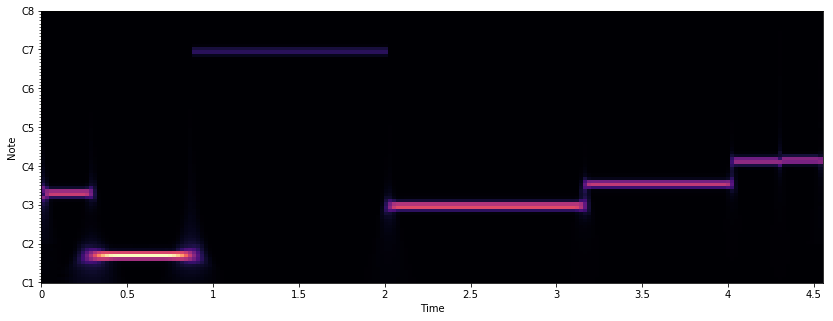

In [64]:
lr.display.specshow(abs(cqt), sr=sr, x_axis='time', y_axis='cqt_note')

[&larr; Back to Index](index.html)